# Pitch-discretization with librosa

## load libs and input signal

In [1]:
# define default samplerate of 44100Hz and not 22050Hz
# and fft length and hop size
from presets import Preset
import librosa as _librosa
import librosa.display as _display
_librosa.display = _display
librosa = Preset(_librosa)

librosa['sr'] = 44100
librosa['n_fft'] = 4096
librosa_hop_len = 2048
librosa['hop_length'] = librosa_hop_len

# other needed modules
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

# ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings('ignore')

#x, sr = librosa.load('../../samples/Toms_diner.wav')
#x, sr = librosa.load('../../samples/sweep_20Hz_20kHz_10s.wav')

#pos = 5
#dur = 10
#x, sr = librosa.load("../../samples/ave-maria.wav", offset=pos, duration=dur)


dur = 10
fmin = 500
fmax = 4*500
sr = 44100
x = librosa.chirp(fmin, fmax, sr=sr, duration=dur)
print("The sine sweep goes from", fmin, "to", fmax, "Hz.")

The sine sweep goes from 500 to 2000 Hz.


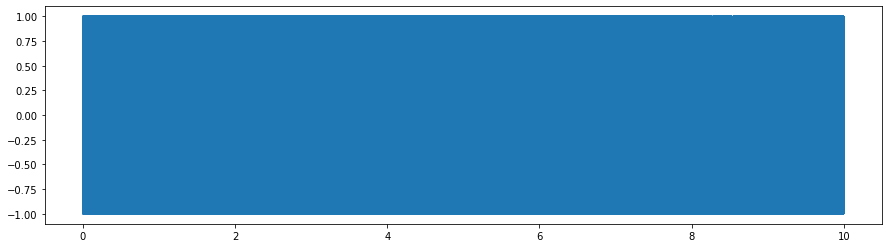

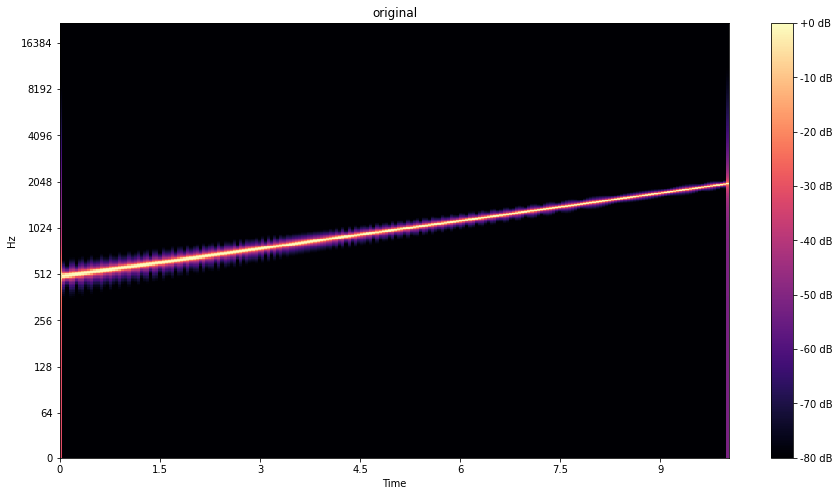

In [2]:
def my_plot(sig, sr, title=''):
    """Plot waveform and spectrogram of signal sig with ramplerate sr."""
    plt.rcParams['figure.figsize'] = [15, 4]
    t = np.linspace(0, sig.size/sr, sig.size)
    plt.plot(t, sig)

    plt.rcParams['figure.figsize'] = [15, 8]
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")

my_plot(x, sr, "original")
ipd.Audio(x, rate=sr)

## pitch-tracking

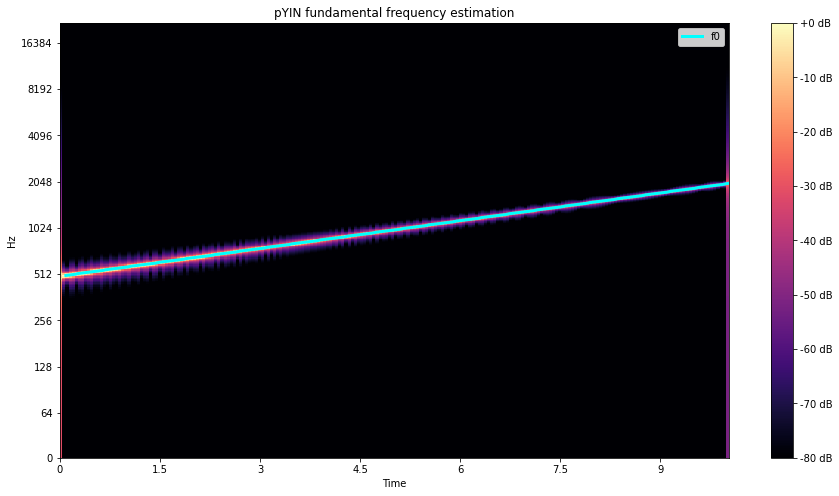

In [3]:
# parameters
fmin = 80
fmax = 2100
frame_len = 2048 # default is 2048

f0, voiced_flag, voiced_probs = librosa.pyin(x, fmin=fmin, fmax=fmax, sr=sr, frame_length=frame_len)

times = librosa.times_like(f0)

D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)

plt.rcParams['figure.figsize'] = [15, 8]
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

## Block Processing

A test for windowed block processing of the signal.

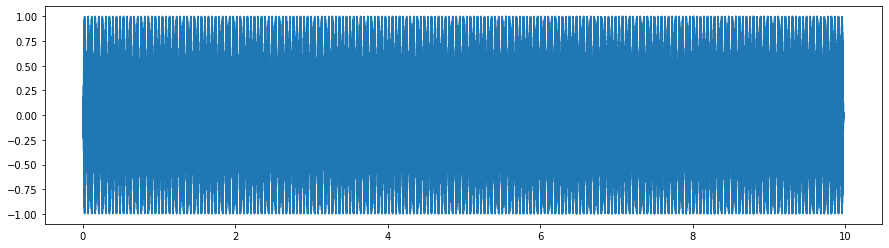

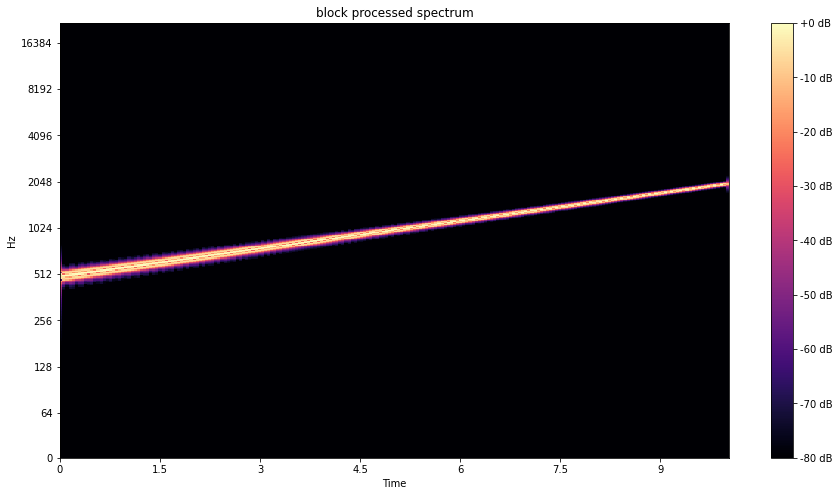

In [4]:
blocksize = librosa_hop_len
n_blocks = f0.size - 1 # avoid last block of some length

w = np.hanning(blocksize)

y = []
# loop over blocks
for i in range(n_blocks):
    pitch = f0[i]
    if np.isnan(pitch):
        # unvoiced
        shifted = x[i*blocksize:(i+1)*blocksize] * w # unprocessed
    else:
        shifted = x[i*blocksize:(i+1)*blocksize] * w
    y.append(shifted)
y = np.concatenate(y)

my_plot(y, sr, "block processed spectrum")
ipd.Audio(y, rate=sr)

## pitch-shifting to constant pitch

We get an
- audio signal
- the analyzed pitch signal
- the pitch analysis hop length (librosa_hop_len)
- the wanted pitch

Now we want to generate a signal with constant pitch, so the pitch shifting factor depends on the pitch of the input signal.

- Figure the blocksize out
- calculate the pitch shifting factor for each block
- do pitch shifting on each block (and do nothing for unvoiced frames or stay constant)

In [5]:
f_out = 600 # desired pitch of the output signal

semitone_ratio = 2**(1/12)

blocksize = librosa_hop_len
n_blocks = f0.size - 1 # avoid last block of some length

w = np.hanning(blocksize)

y_const = []
# loop over blocks
for i in range(n_blocks):
    pitch = f0[i]
    if np.isnan(pitch):
        # unvoiced
        shifted = x[i*blocksize:(i+1)*blocksize] * w # unprocessed
    else:
        # pitch-shifting ratio rho
        rho = f_out / pitch
        # to semitones
        semitones = 12*np.log2(rho)
        # pitch shift
        shifted = librosa.effects.pitch_shift(x[i*blocksize:(i+1)*blocksize], n_steps=semitones) * w
    y_const.append(shifted)
y_const = np.concatenate(y_const)

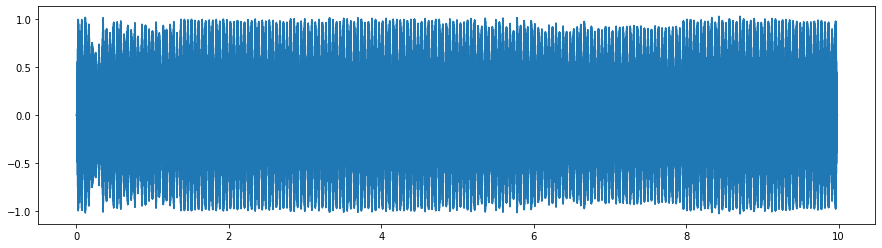

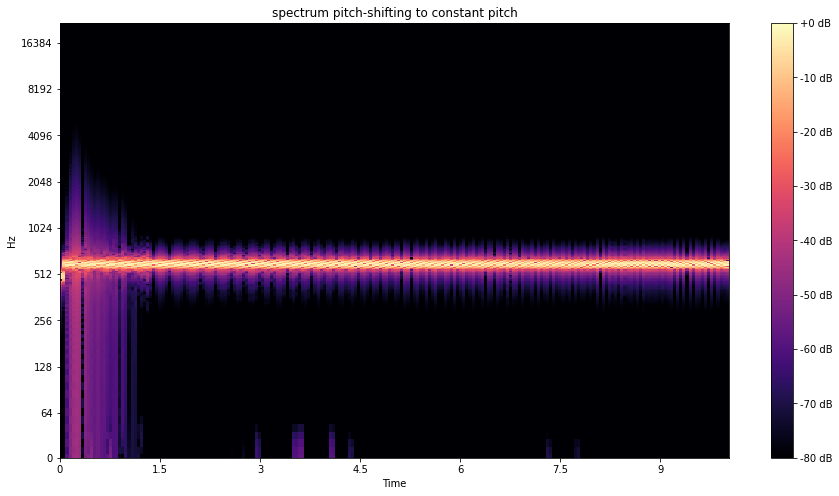

In [6]:
my_plot(y_const, sr, "spectrum pitch-shifting to constant pitch")
ipd.Audio(y_const, rate=sr)

## appearing problems

* Discontinuities if no windowing is applied, because the pitch-shifting algorithm is not for small block processing but rather for shifting a big chunk of continuous audio data.

* The blocksize can not be smaller than 2048 samples because the phase vocoder is hard coded to this fft-size.

So make your own OLA-pitch-shifter for the simplest implementation.

## Pitch discretization

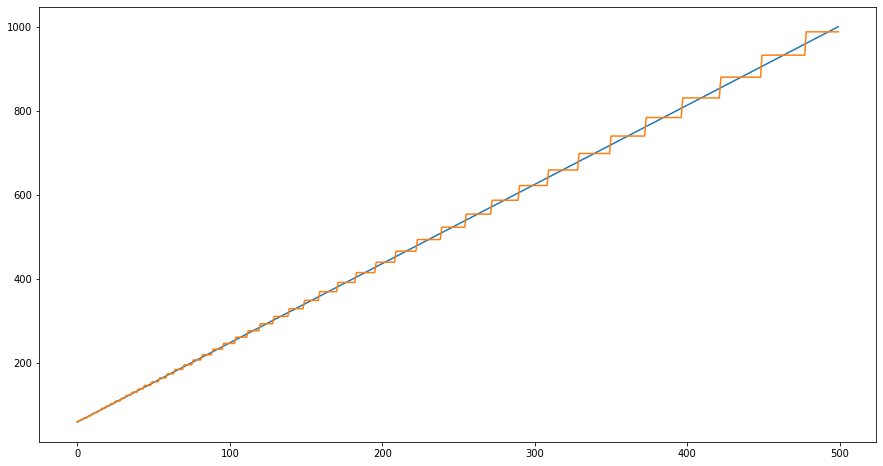

In [7]:
def scale(f0, n_tones=12, tune=440):
    """
    nonlinear frequency scale
    f0...input frequency
    n_tones...make a scale with n_tones tones
    tune...tuning frequency
    return discrete frequencies
    """
    tone = n_tones * np.log2(f0/tune)
    discrete = np.round(tone)
    return tune * (2 ** (discrete / n_tones))

# test scale
f_test = np.linspace(60, 1000, 500)
f_disc = scale(f_test)

plt.plot(f_test)
plt.plot(f_disc)

In [8]:
chromatic = 12
wholetone = 6

# choose scale
s = chromatic

blocksize = librosa_hop_len
n_blocks = f0.size - 1
w = np.hanning(blocksize)
y_disc = []
# loop over blocks
for i in range(n_blocks):
    pitch = f0[i]
    if np.isnan(pitch):
        # unvoiced
        shifted = x[i*blocksize:(i+1)*blocksize] * w # unprocessed
    else:
        f_out = scale(pitch, s)
        # pitch-shifting ratio rho
        rho = f_out / pitch
        # to semitones
        semitones = 12*np.log2(rho)
        # pitch shift
        shifted = librosa.effects.pitch_shift(x[i*blocksize:(i+1)*blocksize], n_steps=semitones) * w
    y_disc.append(shifted)
y_disc = np.concatenate(y_disc)

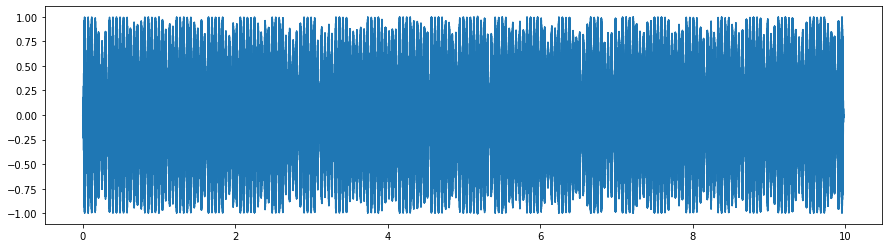

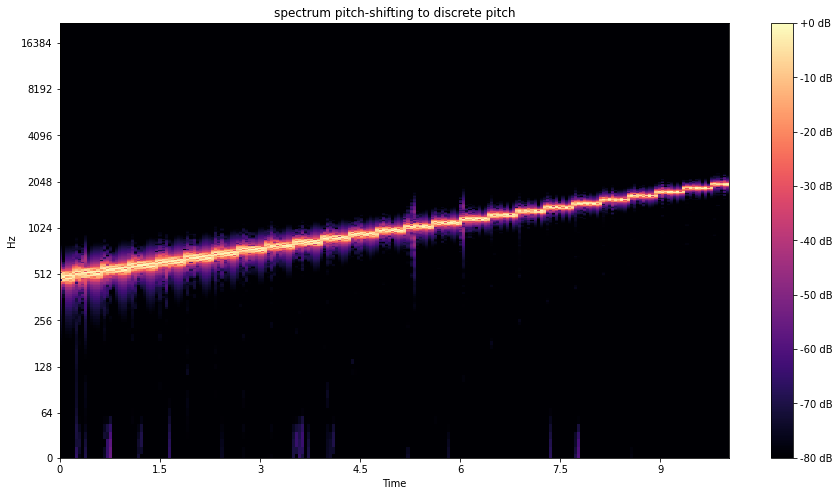

In [9]:
my_plot(y_disc, sr, "spectrum pitch-shifting to discrete pitch")
ipd.Audio(y_disc, rate=sr)

## appearing problems

Amplitude modulation from the windowing appears as the strongest artifact.
This is because there is no overlap of the blocks in the block processing.
This has to be done inside the pitch shifting algorithm, so program your own implementation and check the results with overlap.

## Pitch discretization algorithm design

For analyzing every processing step, every step is done for the whole signal.
Later for the efficient implementation, this is all done in block processing.

Which functions do we need?

On the top level, there is the `reshift()` function, which does the pitch discretization for a whole signal.
So `reshift()` does the pitch analysis and the pitch shifting.
Pitch analysis is done with the librosa implementation of *pYin* for the whole signal.
Then the pitch-shifting factor $\rho[n]$ is calculated for the whole signal.
Now the function `pitch_shift()` does the pitch-shifting according to the pitch-shifting factor.
In this function we can try different algorithms.

1. As a first start, we implement the method from above, which worked OK as a proof of concept.

2. Then we implement pitch-shifting via OLA, so we can have overlaps and its a nice to have comparison.

3. Then we implement the 'Rollers' algorithm for the efficient implementation

4. Then we do testing and check all parameters


### pitch-shift OLA

This method takes

- the audio signal
- the analyzed pitch signal
- the pitch analysis hop length (librosa_hop_len)
- and the wanted scale

and outputs the pitch-shifted signal
(maybe employ some smoothing of pitch transitions?)